###  Recolección y Limpieza de Datos

Importamos la libreria pandas para cargar los datos:

In [1]:
import pandas as pd 

filename = 'https://raw.githubusercontent.com/luisrrc/Recursos-Humanos/main/hr_data.csv'

Cargamos los datos con pandas y creamos el DataFrame:

In [2]:
df = pd.read_csv(filename)

df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,is_smoker,department,salary
0,0.38,0.53,2,157.0,3.0,0,yes,0,NaN,sales,low
1,0.80,0.86,5,262.0,6.0,0,yes,0,yes,sales,medium
2,0.11,0.88,7,272.0,4.0,0,yes,0,NaN,sales,medium
3,0.72,0.87,5,223.0,5.0,0,yes,0,NaN,sales,low
4,0.37,0.52,2,NaN,NaN,0,yes,0,no,sales,low


Revisamos las columnas:

In [3]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'is_smoker', 'department', 'salary'],
      dtype='object')

Ahora, veremos las últimas filas del DataFrame:

In [4]:
df.tail()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,is_smoker,department,salary
14994,0.40,0.57,2,151.0,3.0,0,yes,0,NaN,support,low
14995,0.37,0.48,2,160.0,3.0,0,yes,0,NaN,support,low
14996,0.37,0.53,2,143.0,3.0,0,yes,0,NaN,support,low
14997,0.11,0.96,6,280.0,4.0,0,yes,0,NaN,support,low
14998,0.37,0.52,2,158.0,3.0,0,yes,0,NaN,support,low


Se puede ver que se han cargado los datos correctos, ya que según el índice se reflejan casi 15000 filas.

Se chequea el total de filas que contiene el  DataFrame:

In [5]:
len(df)

14999

Ahora, se observará como está distribuida nuestra variable target (left):

In [6]:
df.left.value_counts()

no     11428
yes     3571
Name: left, dtype: int64

Esto se puede visualizar de la siguiente manera:

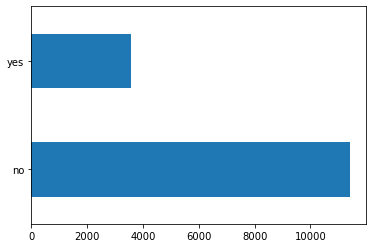

In [7]:
df.left.value_counts().plot(kind ='barh')

Segun la grafica podemos ver que acerca de tres cuartos de las muestras son empleados que no se fueron. Esto nos dice que estamos tratando con un problema de clasificacion desbalanceado, lo cual implica que se tendrá que tomar medidas especiales para contar cada clase cuando se calcule su precisión.

Ahora, se buscan valores nulos:

In [8]:
df.left.isnull().sum()

0

Se revisa el tipo de datos en cada columna:

In [9]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours     float64
time_spend_company       float64
work_accident              int64
left                      object
promotion_last_5years      int64
is_smoker                 object
department                object
salary                    object
dtype: object

Vamos a ver como están distribuidas las features usando matplotlib:

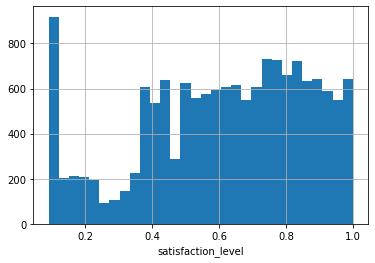

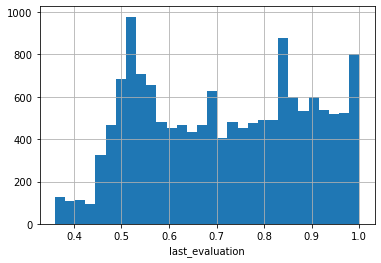

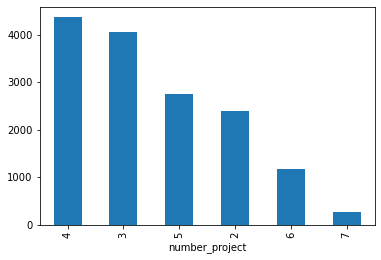

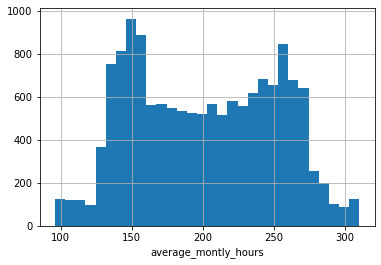

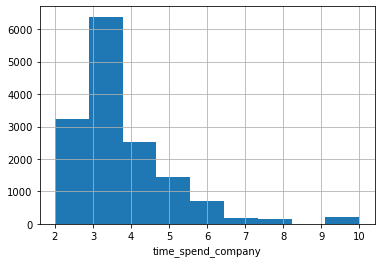

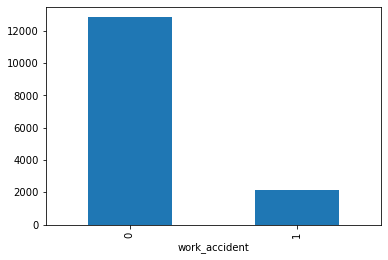

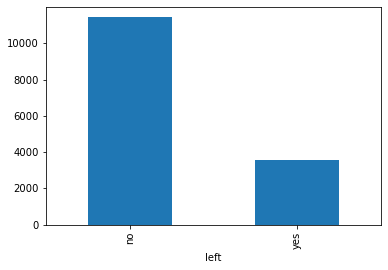

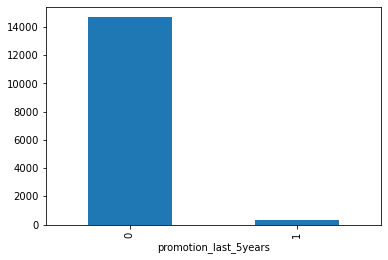

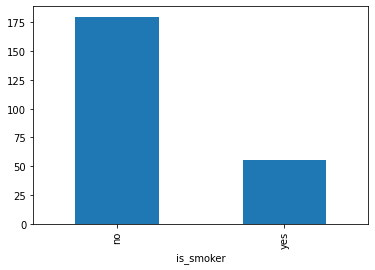

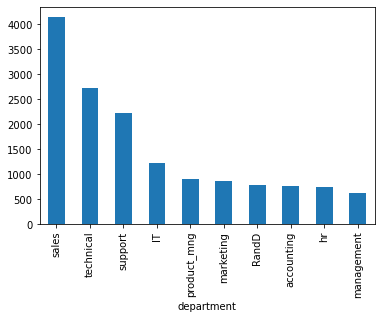

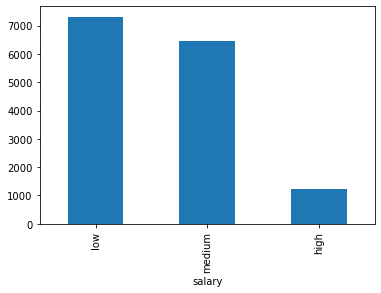

In [10]:
from matplotlib import pyplot as plt

for f in df.columns:
    
    fig = plt.figure()
    
    s = df[f]
    
    if s.dtype in ('float', 'int'):
        
        num_bins = min((30, len(df[f].unique())))
        
        s.hist(bins = num_bins)
        
    else:
        
        s.value_counts().plot.bar()
        
    plt.xlabel(f)

Se puede ver que existe una amplia distribucion entre los valores posibles, lo que indica una buena variedad en cada feature. También podemos apreciar que  las variables que están fuertemente agrupadas alrededor de un pequeño rango de valores pueden no ser muy informativas para nuestro modelo. Por ejemplo, podemos ver que en el caso de "promotion_last_5years, la gran mayoría de muestran son 0. 

Se necesita buscar cuantos valores NaN hay en cada columna:

In [11]:
df.isnull().sum() / len(df) * 100

satisfaction_level        0.000000
last_evaluation           0.000000
number_project            0.000000
average_montly_hours      2.453497
time_spend_company        1.006734
work_accident             0.000000
left                      0.000000
promotion_last_5years     0.000000
is_smoker                98.433229
department                0.000000
salary                    0.000000
dtype: float64

Se puede ver que hay acerca de un 2.5% faltante para average_monthly_hours, 1% faltante para time_spend_company y 98% faltante para is_smoker.

Se necesita quitar la columna is_smoker column ya que no nos será útil para el estudio. 

In [12]:
del df['is_smoker']

Se rellenan los valores NaN values en la columna time_spend_company con la mediana:

In [13]:
fill_value = df.time_spend_company.median()

df.time_spend_company = df.time_spend_company.fillna(fill_value)

La otra columna a tratar es average_montly_hours. Podríamos implementar algo similar a lo que hicimos anteriormente y usar la mediana o la media como un valor entero. En vez de realizar eso intentaremos tomar ventaja de su relación con otra variable, esto quizás nos permita rellenar los datos faltantes con mayor precisión.

In [14]:
df.isnull().sum() / len(df) * 100

satisfaction_level       0.000000
last_evaluation          0.000000
number_project           0.000000
average_montly_hours     2.453497
time_spend_company       0.000000
work_accident            0.000000
left                     0.000000
promotion_last_5years    0.000000
department               0.000000
salary                   0.000000
dtype: float64

Se hará un gráfico de caja de average_montly_hours segmentados por number_project:

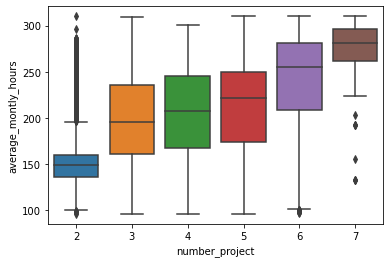

In [15]:
import seaborn as sns

sns.boxplot(x = 'number_project', y = 'average_montly_hours', data = df)

Vemos que el número de proyectos está correlacionado con average_monthly_hours. Usaremos esta relación para rellenar los valores NaN de average_montly_hours basados en el número de proyetos por registro. Estaremos usando la media de cada grupo.

Se calcula la media de cada grupo:

In [16]:
mean_per_project = (df.groupby('number_project').average_montly_hours.mean())

mean_per_project = dict(mean_per_project)

mean_per_project

{2: 160.16353543979506,
 3: 197.47882323104236,
 4: 205.07858315740089,
 5: 211.99962839093274,
 6: 238.73947368421054,
 7: 276.015873015873}

Luego, se traza esto dentro de la columna number_project y pasar el objeto de serie resultante como argumento de fillna.

Se rellena los valores NaN en average_montly_hours:

In [17]:
fill_values = df.number_project.map(mean_per_project)

df.average_montly_hours = (df.average_montly_hours.fillna(fill_values))

Para confirmar que el DataFrame no tiene mas valores NaN, se ejecuta una prueba de aserción:

In [18]:
assert df.isnull().sum().sum() == 0

Ahora debemos transformar los campos que tienen valores de caracteres y booleanos por enteros. En particular, convertiremos la variable target "left" de yes y no en 1 y 0, construyendo el one-hot encoded features:

In [19]:
df.left = df.left.map({'no' : 0, 'yes': 1})

df = pd.get_dummies(df)

Vamos a revisar las columnas:

In [20]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

Ahora que completamos la etapa de preprocesamiento de datos y estamos listos para entrenar modelos, vamos a guardar nuestra data preprocesada:

In [21]:
df.to_csv('C:/Users/luis_/OneDrive/Documentos/rh_datos_procesados.csv', index = False)

Estaremos entrenando modelos de clasificación en dos conjuntos de variables continuas: satisfaction_level and last_evaluation. Basado en sus histogramas, los cuales ejecutamos previamente, se puede observar como ellos están distribuidos  uniformemente entre 0 y 1. Ahora, echemos una mirada a como ellos están distribuidos el uno con respecto al otro.

Vamos a observar de cerca a nuestra variable target, left, la cual tiene los siguientes valores:

1 (True) si el empleado se fue de la compañía

0 (False) si el empleado sigue trabajando en la compañía

Crearemos el gráfico bivariado y univariado de las dos features: 

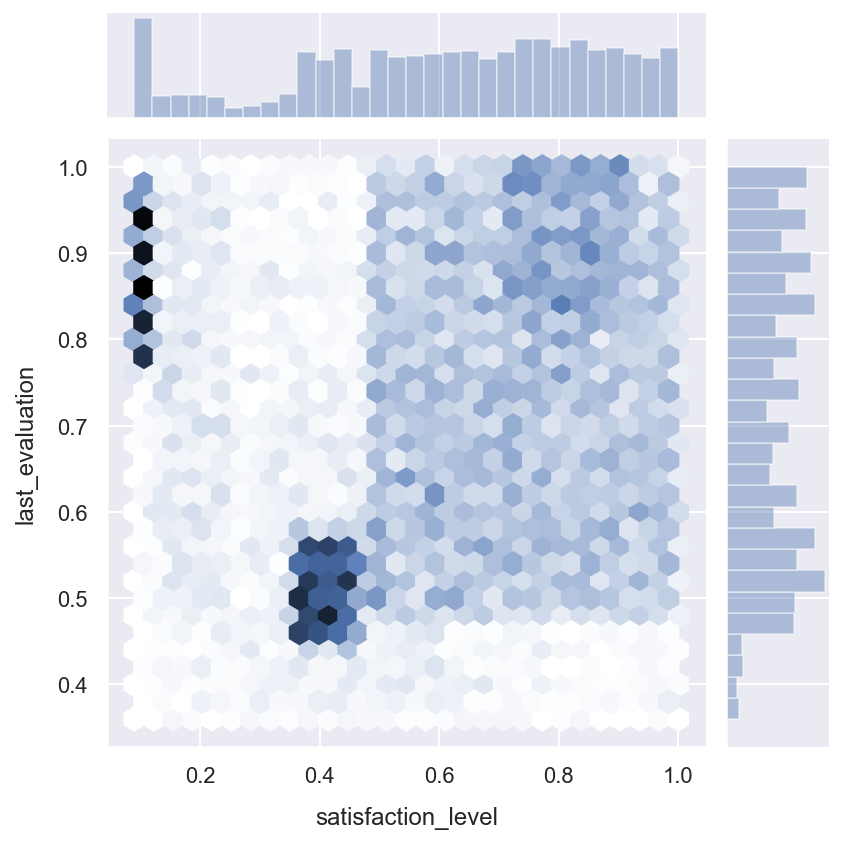

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.labelpad'] = 10
sns.set_style("darkgrid")

sns.jointplot(x='satisfaction_level', y='last_evaluation', data=df,
    kind='hex')

plt.savefig('C:/Users/luis_/OneDrive/Documentos/figures-jointplot.png',bbox_inches='tight',
            dpi=300,)

Este gráfico de densidad es útil pero vamos a segmentarlo en la variable target de manera que cada clase sea representada por un color diferente.

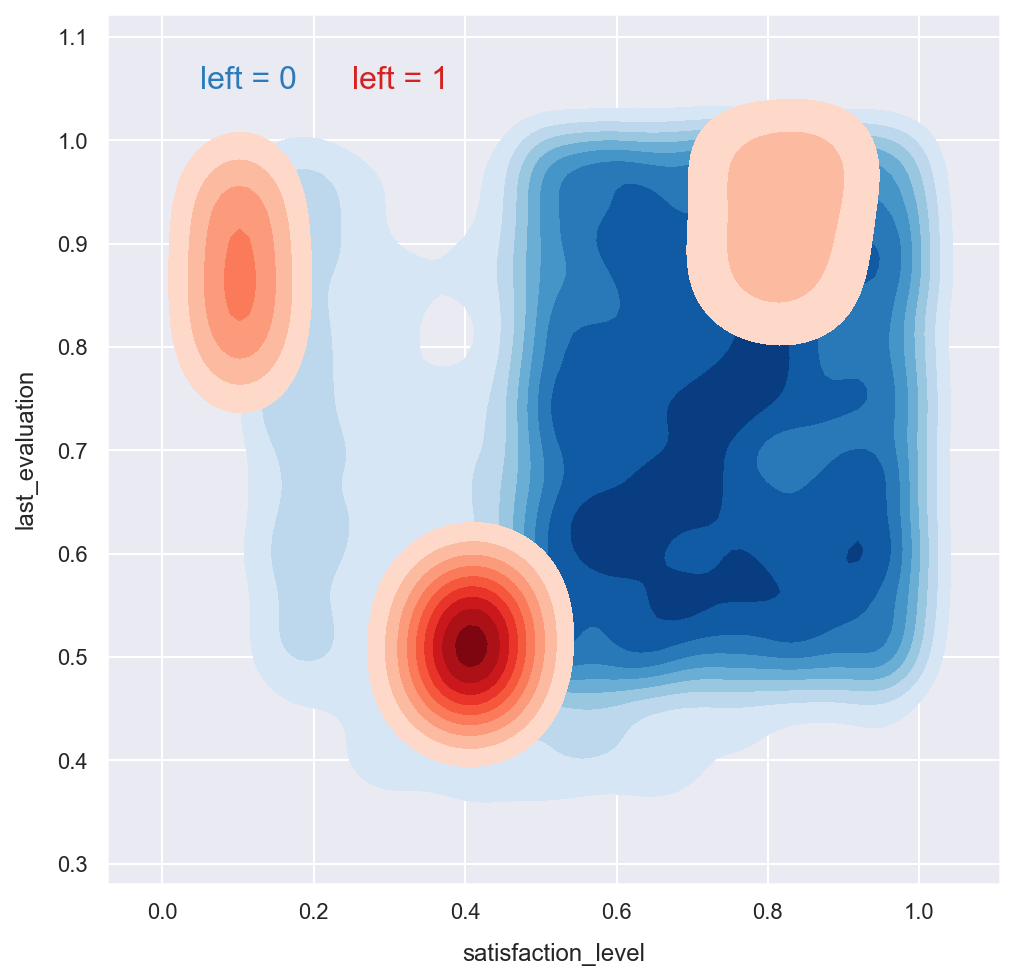

In [23]:
fig, ax = plt.subplots()

plot_args = dict(shade=True, shade_lowest=False)

for i, c in zip((0, 1), ('Blues', 'Reds')):
    
    sns.kdeplot(df.loc[df.left==i, 'satisfaction_level'], df.loc[df.left==i, 'last_evaluation'],
        cmap=c, **plot_args)

ax.text(0.05, 1.05, 'left = 0', size=16, color=sns.color_palette('Blues')[-2])

ax.text(0.25, 1.05, 'left = 1', size=16, color=sns.color_palette('Reds')[-2])

plt.savefig(
    'C:/Users/luis_/OneDrive/Documentos/figures-bivariate-segmented.png',
    bbox_inches='tight', dpi=300)

 Se puede apreciar como se relacionan los atributos con la variable target. Vamos a intentar sacar ventaja de esos atributos para entrenar modelos de clasificación.

# Modelado de Datos

## Entrenamiento de Modelo con el clasificador Support Vector Machine

Se divide los datos en conjunto de entrenamiento y conjunto de prueba:

In [24]:
from sklearn.model_selection import train_test_split

features = ['satisfaction_level', 'last_evaluation']

X_train, X_test, y_train, y_test = train_test_split(df[features].values, df['left'].values, test_size = 0.3, random_state = 1)

Ahora se importa el StandardScaler para crear una nueva instancia, llamada la variable scaler. Luego se ajusta en el conjunto de entrenamiento y por último la transforma, antes de transformar finalmente el conjunto de prueba:

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)

X_test_std = scaler.transform(X_test)

Importamos scikit-learn SVM class, SVC, y ajustamos el modelo en el conjunto de entrenamiento:

In [26]:
from sklearn.svm import SVC

svm = SVC(kernel = 'linear', C = 1, random_state = 1, gamma = 'scale')

svm.fit(X_train_std, y_train)

SVC(C=1, kernel='linear', random_state=1)

Vamos a ver la precisión del modelo en los datos no entrenados (conjunto de prueba):

In [27]:
from sklearn.metrics import accuracy_score

y_pred = svm.predict(X_test_std)

acc = accuracy_score(y_test, y_pred)

print('precisión = {:.1f}%'.format(acc*100))

precisión = 75.9%


El resultado es 75.9 % de precisión, el cual no es tan malo tomando en cuenta que es el primer modelo. Es importante resaltar que las clases en nuestra variable target están altamente desbalanceadas, ya que la mayoria de registros en los datos corresponden a empleados que aun trabajan en la compañía. Teniendo en cuenta esto, necesitamos enfocarnos en la precisión de cada clase además de la precisión general.

Se observa la precisión de cada clase en la variable target, usando una matriz de confusión:

In [28]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_test, y_pred)

print(cmat)

[[3416    0]
 [1084    0]]


El modelo está haciendo una predicción de todos los registros de prueba como clase 0 y muestra 1084 falsos negativos, definitivamente esto no es bueno.

Vamos a examinar porcentualmente la matriz de confusión para ver como están las precisiones por clase: 

In [29]:
print('porcentaje de precisión por clase: ')

cmat = confusion_matrix(y_test, y_pred)

scores = cmat.diagonal() / cmat.sum(axis = 1) * 100

print('left = 0 : {:.2f}%'.format(scores[0]))

print('left = 1 : {:.2f}%'.format(scores[1]))

porcentaje de precisión por clase: 
left = 0 : 100.00%
left = 1 : 0.00%


Como era de esperarse, el modelo esta clasificando cada muestra como 0, esto significa que esta prediciendo que no hay empleados en el conjunto de prueba que dejaran la compañía. Se usará un gráfico de contorno para mostrar la clase predicha en cada punto del espacio de la variable.

Se trazará una gráfica de regiones de decisión con la librería mlxtend:

C:\Users\luis_\Anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:244: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


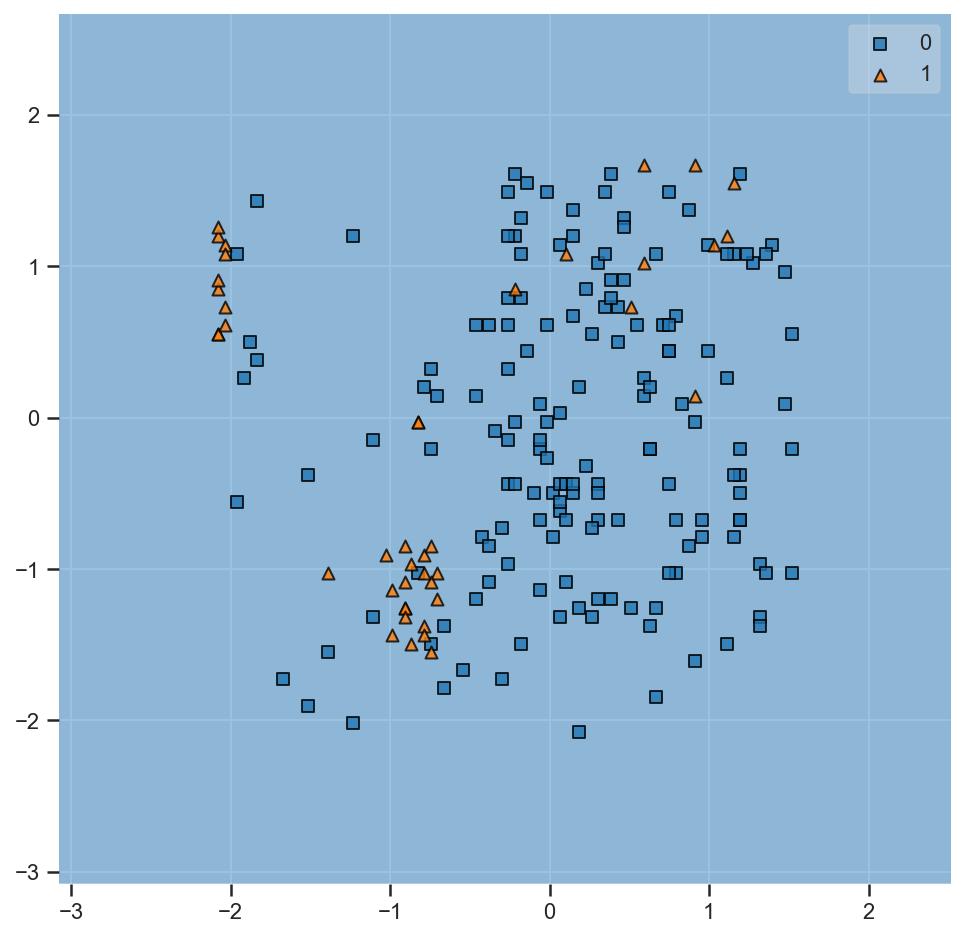

In [30]:
from mlxtend.plotting import plot_decision_regions

N_samples = 200

X, y = X_train_std[:N_samples], y_train[:N_samples]

plot_decision_regions(X, y, clf = svm)

Vemos que el resultado es casi completamente azúl, indicando que cada punto en el espacio sera clasificado como 0. Podemos ver que un modelo lineal no puede hacer un buen trabajo para describir atributos no lineales.

In [31]:
# The docstring for scikit-learn's SVM

SVC?

Se elige el kernel rbf como opción para entrenar un nuevo SVM: 

In [32]:
svm = SVC(kernel = 'rbf', C = 1, random_state = 1, gamma = 'scale')

svm.fit(X_train_std, y_train)

SVC(C=1, random_state=1)

Vamos a juntar los pasos anteriores en una función llamada check_model_fit, que aceptará un modelo entrenado, junto con los datos de la prueba, y producirá los puntajes de precisión y el gráfico de límites de decisión que nos interesan:

In [33]:
from IPython.display import display

def check_model_fit(clf, X_test, y_test):
    
    # Ejecuta la precisión general del test-set
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred, normalize = True) * 100
    print('precisión total = {:.1f}%'.format(acc))
    
    # Ejecuta la matriz de confusión
    cmat = confusion_matrix(y_test, y_pred)
    cols = pd.MultiIndex.from_tuples([('predictions', 0), ('predictions', 1)])
    indx = pd.MultiIndex.from_tuples([('actual', 0), ('actual', 1)])
    display(pd.DataFrame(cmat, columns = cols, index = indx))
    print()
    
    # Ejecuta la precisión del test-set agrupado por la variable target 
    print('porcentaje de precisión por clase:')
    cmat = confusion_matrix(y_test, y_pred)
    scores = cmat.diagonal() / cmat.sum(axis = 1) * 100
    print('left = 0 : {:.2f}%'.format(scores[0]))
    print('left = 1 : {:.2f}%'.format(scores[1]))
    print()
    
    # Trazar las regiones de decisión
    fig = plt.figure(figsize=(8, 8))
    N_samples = 200
    X, y = X_test[:N_samples], y_test[:N_samples]
    plot_decision_regions(X, y, clf=clf)
    
    plt.xlabel('satisfaction_level')
    plt.ylabel('last_evaluation')
    plt.legend(loc='upper left')

Ahora, ejecutamos la función check_model_fit para el nuevo modelo entrenado kernel SVM:

precisión total = 89.7%


predictions     
                   0    1
actual 0        3308  108
       1         354  730


porcentaje de precisión por clase:
left = 0 : 96.84%
left = 1 : 67.34%



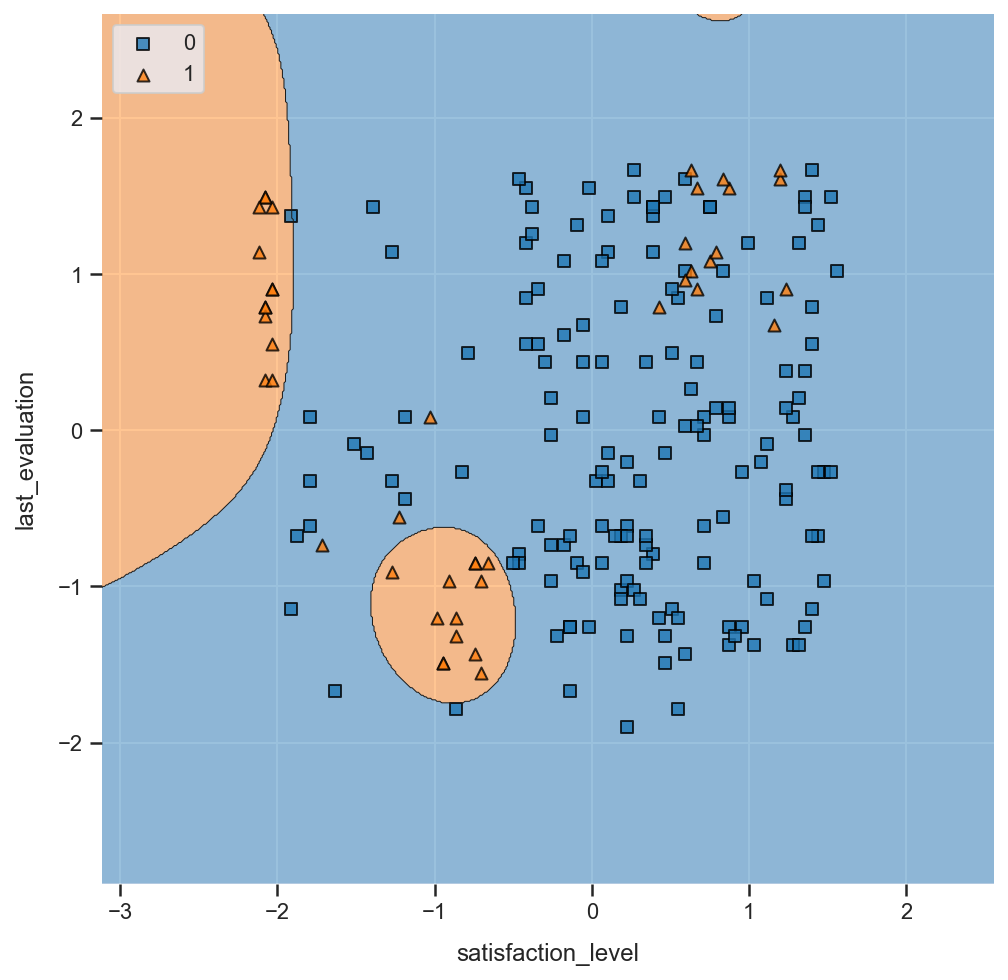

In [34]:
check_model_fit(svm, X_test_std, y_test)

Este resultado está mejor. Podemos ver una precisión general cercana al 90%, donde la precisión de la clase 1 es 67% comparado con el 0% del linear SVM. 

 ## Entrenando con el clasificador k-Nearest Neighbors 

Anteriormente vimos como un linear SVM y kernel SVM se desempeñaron de maneras muy diferentes, seleccionando dos variables para el modelo. Aquí continuaremos modelando con esas dos variables, satisfaction_level and last_evaluation, usando el algoritmo KNN.

In [35]:
from sklearn.neighbors import KNeighborsClassifier 

KNeighborsClassifier?

Entrenaremos el clasificador KNN con n_neighbors = 3, y luego ejecutamos la precisión y las regiones de decisión:

precisión total = 90.9%


predictions     
                   0    1
actual 0        3203  213
       1         198  886


porcentaje de precisión por clase:
left = 0 : 93.76%
left = 1 : 81.73%



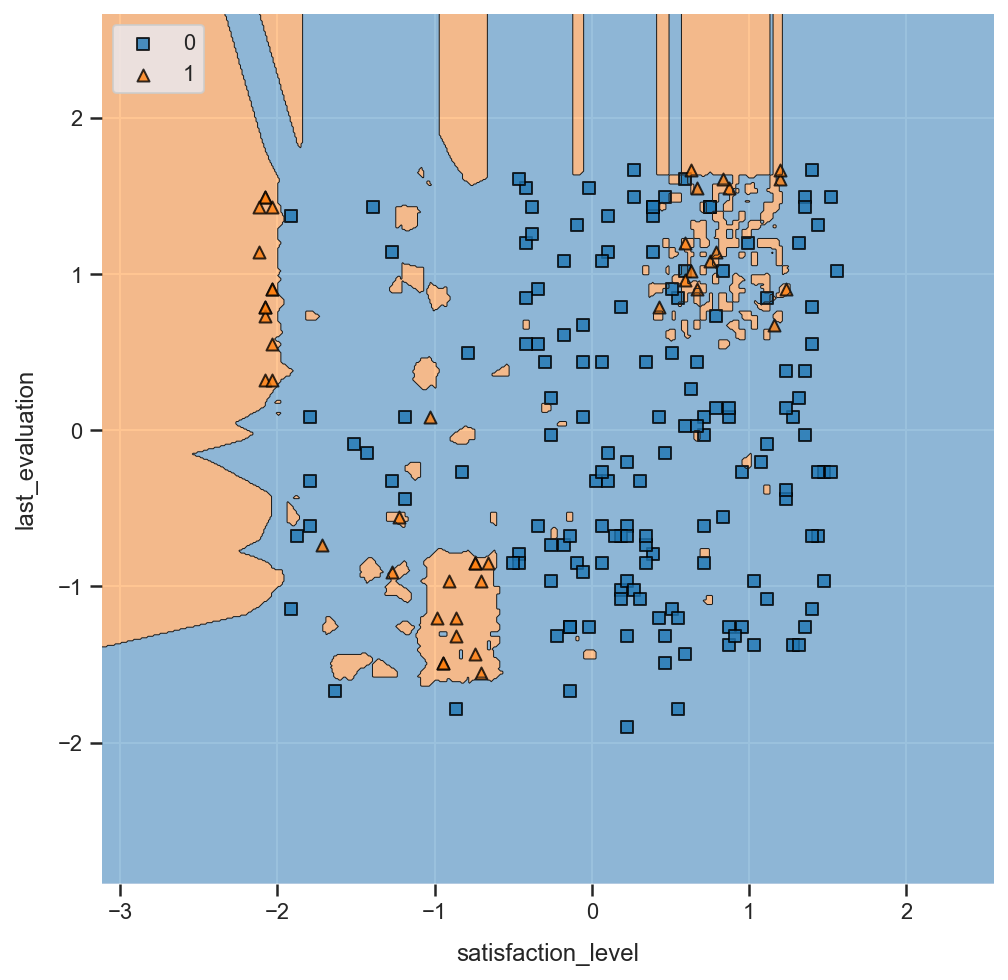

In [36]:
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train_std, y_train)

check_model_fit(knn, X_test_std, y_test)

Aquí, vemos que incremento la precisión general sobre el 90 %, también hubo una mejora significativa para la clase 1 en particular con una precisión cercana al 82 %. Sin embargo, el gráfico de regiones indica que hemos sobre ajustado los datos. Esto se puede mejorar incrementando el número de vecinos cercanos en el clasificador.

Para reducir el sobre ajuste, se entrenará un modelo KNN con n_neighbors = 25:

precisión total = 91.6%


predictions     
                   0    1
actual 0        3290  126
       1         254  830


porcentaje de precisión por clase:
left = 0 : 96.31%
left = 1 : 76.57%



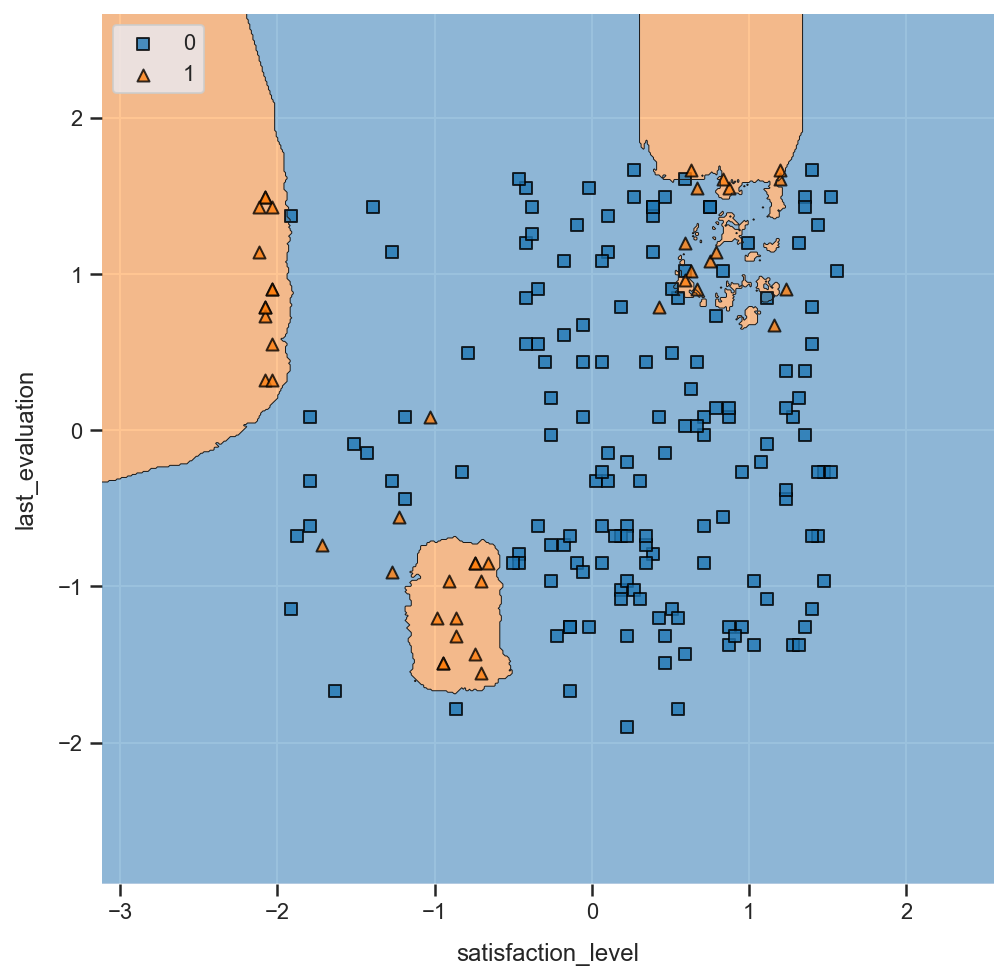

In [37]:
knn = KNeighborsClassifier(n_neighbors = 25)

knn.fit(X_train_std, y_train)

check_model_fit(knn, X_test_std, y_test)

Como podemos ver, los límites de decisión están significativamente menos entre cortados en comparación con la gráfica del modelo n_neighbors = 3.

Observando las métricas, la precisión de la clase 1 es menor, se necesita usar un método mas completo (como el k-fold cross validation) para decidir si hay una diferencia significativa entre este modelo y el modelo n_neighbors = 3 que entrenamos previamente.

## Entrenando el clasificador Random Forest 

Ahora, entrenaremos con el clasificador Random Forest Classifier y compararemos su resultado con los algoritmos anteriores.

In [38]:
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier?

Entrenaremos un modelo de clasificación con Random Forest compuesto de 50 árboles de decisión, cada uno con el max depth = 5.

Entrenando el clasificador Random Forest:

precisión total = 92.0%


predictions     
                   0    1
actual 0        3371   45
       1         317  767


porcentaje de precisión por clase:
left = 0 : 98.68%
left = 1 : 70.76%



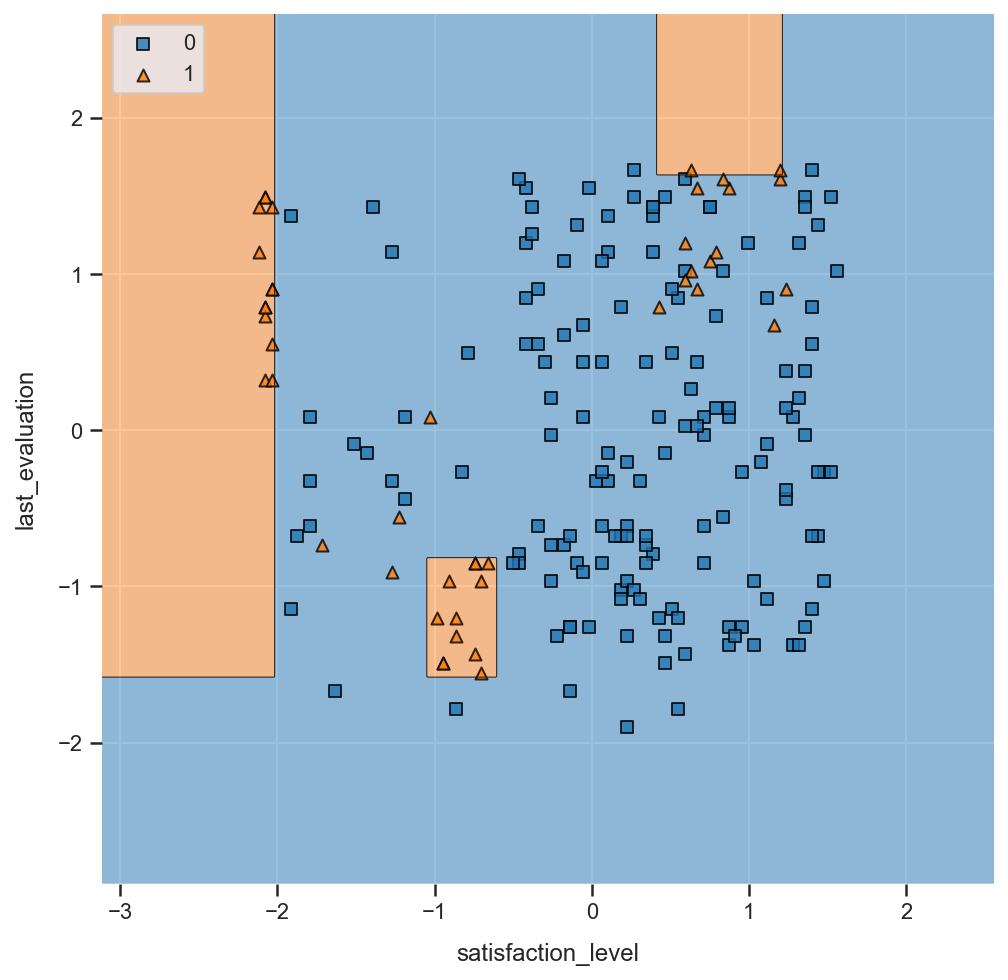

In [39]:
forest = RandomForestClassifier(n_estimators = 50, max_depth = 5, random_state = 1)

forest.fit(X_train_std, y_train)

check_model_fit(forest, X_test_std, y_test)